In [1]:
import numpy as np
import pandas as pd 
!conda run -n tf_on_gpu python3 -m pip install -q "dask[diagnostics]"
import dask.dataframe as ddf
import uproot
from os import environ



/usr/local/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from glob import glob
file_pattern = "/workarea/local/private/cache/data/j100/*.root"
default_file_list = glob(file_pattern)
file_list = environ.get("INPUT_FILES", " ".join(default_file_list)).split(" ")

print (f"Found {len(file_list)} files from {file_pattern}")  

Found 10 files from /workarea/local/private/cache/data/j100/*.root


In [3]:
def read_root(filename, tree=None):
    if tree is None:
        return uproot.open(filename)
    
    return pd.DataFrame(uproot.open(filename)[tree].arrays(library='np'))

from functools import partial
reco = (ddf
        .from_map (partial(read_root, tree="TrackingTupler/reco"), file_list)
        .query("(type == 3) or (type == 4) or (type == 5)")
       )

In [4]:
n_rows = len(reco.columns)//4
print ("\n".join([" ".join([f"{c:24s}" for c in reco.columns[i::n_rows]]) for i in range(n_rows)]))

mc_key                   true_mass_ClosestToBeam  cov_BegRich1_0_1         cov_AtT_1_3              cov_EndRich2_3_4        
evtNumber                x_ClosestToBeam          cov_BegRich1_1_1         cov_AtT_2_3              cov_EndRich2_4_4        
runNumber                y_ClosestToBeam          cov_BegRich1_0_2         cov_AtT_3_3             
PID                      z_ClosestToBeam          cov_BegRich1_1_2         cov_AtT_0_4             
clone                    qop_ClosestToBeam        cov_BegRich1_2_2         cov_AtT_1_4             
purity                   cov_ClosestToBeam_0_0    cov_BegRich1_0_3         cov_AtT_2_4             
type                     cov_ClosestToBeam_0_1    cov_BegRich1_1_3         cov_AtT_3_4             
history                  cov_ClosestToBeam_1_1    cov_BegRich1_2_3         cov_AtT_4_4             
fitHistory               cov_ClosestToBeam_0_2    cov_BegRich1_3_3         px_BegRich2             
ghostProb                cov_ClosestToBeam_1_2    

In [5]:
reco['mc_log10_p'] = np.log10(reco.mc_p)
reco['mc_is_e'] = abs(reco.PID).isin([11]).astype(np.float32)
reco['mc_is_mu'] = abs(reco.PID).isin([13]).astype(np.float32)
reco['mc_is_h'] = abs(reco.PID).isin([211, 321, 2212]).astype(np.float32)
reco['long'] = (reco.type==3).astype(np.float32)
reco['upstream'] = (reco.type==4).astype(np.float32)
reco['downstream'] = (reco.type==5).astype(np.float32)
reco['dx'] = reco.x_ClosestToBeam - reco.true_x_ClosestToBeam
reco['dy'] = reco.y_ClosestToBeam - reco.true_y_ClosestToBeam
reco['dz'] = reco.z_ClosestToBeam - reco.true_z_ClosestToBeam
reco['dtx'] = reco.tx_ClosestToBeam - reco.true_tx_ClosestToBeam
reco['dty'] = reco.ty_ClosestToBeam - reco.true_ty_ClosestToBeam
reco['dp'] = reco.reco_p - reco.mc_p
reco = reco.map_partitions(lambda df: df.assign(nDoF_f = df.nDoF + np.random.uniform(0, 1, len(df))))


res_real_conditions = [
    'true_x_ClosestToBeam', 'true_y_ClosestToBeam', 'true_z_ClosestToBeam', 
    'true_tx_ClosestToBeam', 'true_ty_ClosestToBeam', 'mc_log10_p'
]

res_flags = ['mc_is_e', 'mc_is_mu', 'mc_is_h', 'long', 'upstream', 'downstream']

res_conditions = res_real_conditions + res_flags
res_target = ['dx', 'dy', 'dz', 'dtx', 'dty', 'dp', 'chi2PerDoF', 'nDoF_f', 'ghostProb']

In [6]:
df = reco[res_conditions + res_target].head(300_000, npartitions=10)
df

,true_x_ClosestToBeam,true_y_ClosestToBeam,true_z_ClosestToBeam,true_tx_ClosestToBeam,true_ty_ClosestToBeam,mc_log10_p,mc_is_e,mc_is_mu,mc_is_h,long,...,downstream,dx,dy,dz,dtx,dty,dp,chi2PerDoF,nDoF_f,ghostProb
0,0.573766,-0.504192,5.343706,0.136734,0.155601,3.794627,0.0,0.0,1.0,1.0,...,0.0,-0.002566,0.021092,-0.008306,-0.000227,-0.000460,-5.286621,1.015763,30.211203,0.006457
2,0.727226,0.200873,10.719674,-0.032421,0.117373,3.357954,0.0,0.0,1.0,1.0,...,0.0,0.085674,-0.099873,-0.268574,-0.001063,0.001247,-9.628418,0.866766,38.348024,0.004073
3,0.321377,-0.521502,-11.688612,0.027271,0.016806,4.028106,0.0,0.0,1.0,1.0,...,0.0,0.069323,-0.065798,1.786812,-0.000060,0.000454,50.350586,0.910281,33.787700,0.003543
4,0.218335,0.280382,16.488998,-0.067375,0.052465,3.671158,0.0,0.0,1.0,1.0,...,0.0,0.010765,-0.115082,-0.718598,0.000362,0.001003,3.974121,0.745428,38.924669,0.002595
5,0.111747,-0.403851,21.429649,-0.051381,-0.014217,4.089846,0.0,0.0,1.0,1.0,...,0.0,-0.042447,0.019251,1.217850,-0.000184,-0.000240,17.000000,1.012854,40.542579,0.023526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44509,0.741029,0.163753,-51.839146,0.012476,-0.056459,3.917769,0.0,0.0,1.0,1.0,...,0.0,1.085071,0.362747,1.880047,-0.002045,-0.001622,-171.697754,1.225178,29.378275,0.020100
44510,0.830669,-0.094383,-42.360165,0.003479,0.030621,3.838578,0.0,0.0,1.0,1.0,...,0.0,0.172731,0.014883,5.235565,-0.000398,0.000706,0.297852,0.843934,31.470291,0.004302
44511,0.742185,-0.369345,-16.887154,0.033525,0.067367,3.943779,0.0,0.0,1.0,0.0,...,0.0,-0.006785,0.003745,0.253954,0.000102,0.000122,3192.511719,1.319449,13.433248,0.059842
44515,0.519034,-0.492174,-6.532609,-0.049847,-0.052567,3.996593,0.0,0.0,1.0,1.0,...,0.0,0.043666,0.015674,1.521009,-0.000918,-0.000590,-9.393555,1.156296,31.687849,0.004501


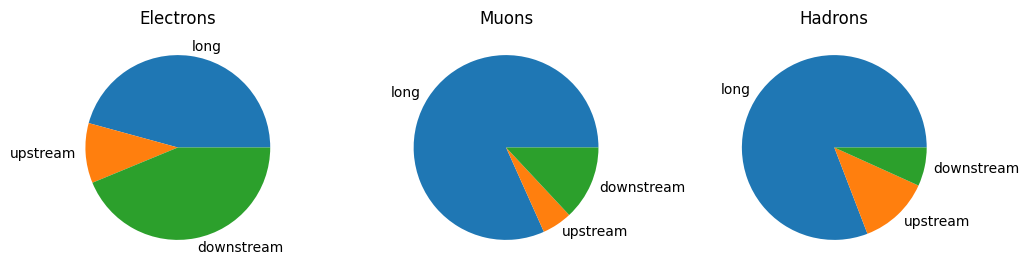

In [7]:
import matplotlib.pyplot as plt

classes = "long", "upstream", "downstream"
plt.figure(figsize=(12,3))
for iPlot, part in enumerate(('e', 'mu', 'h'), 1):
    plt.subplot(1,3,iPlot)
    pdf = df.query(f'mc_is_{part}==1')
    counts = [np.count_nonzero(pdf[c]) for c in classes]
    plt.pie(counts, labels=classes)
    plt.title(dict(e='Electrons', mu="Muons", h="Hadrons")[part])



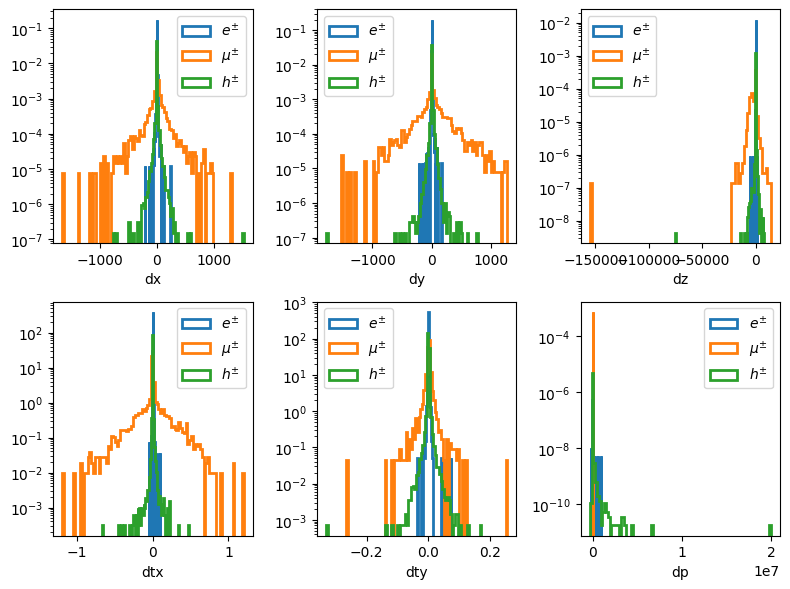

In [8]:
pure_res_vars = res_target[:6]

plt.figure(figsize=(8,6))
for iPlot, var in enumerate(pure_res_vars, 1):
    for part in ('e', 'mu', 'h'):
        plt.subplot(2,3,iPlot)
        label=dict(e='$e^{\pm}$', mu="$\mu^{\pm}$", h="$h^{\pm}$")[part]
        plt.hist(df.query(f'mc_is_{part}==1')[var], bins=100, label=label, histtype='step', linewidth=2, density=True)
        plt.xlabel(var)
        plt.yscale('log')
        plt.legend()

plt.tight_layout()
plt.show()


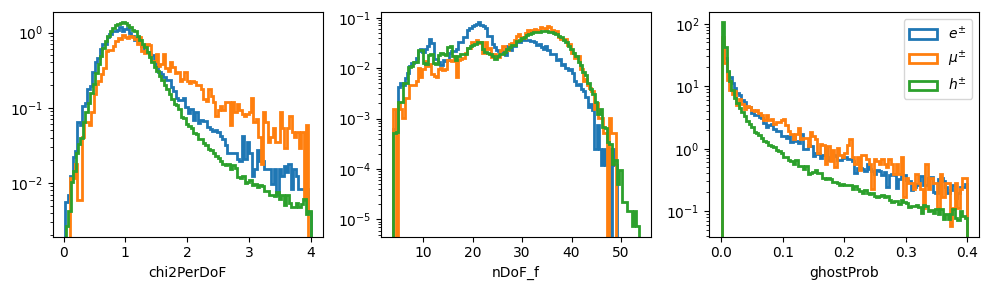

In [9]:
track_quality = res_target[6:]

plt.figure(figsize=(10,3))
for iPlot, var in enumerate(track_quality, 1):
    for part in ('e', 'mu', 'h'):
        plt.subplot(1,3,iPlot)
        label=dict(e='$e^{\pm}$', mu="$\mu^{\pm}$", h="$h^{\pm}$")[part]
        plt.hist(df.query(f'mc_is_{part}==1')[var], bins=100, label=label, histtype='step', linewidth=2, density=True)
        plt.xlabel(var)
        plt.yscale('log')
        if iPlot==3: plt.legend()

plt.tight_layout()
plt.show()


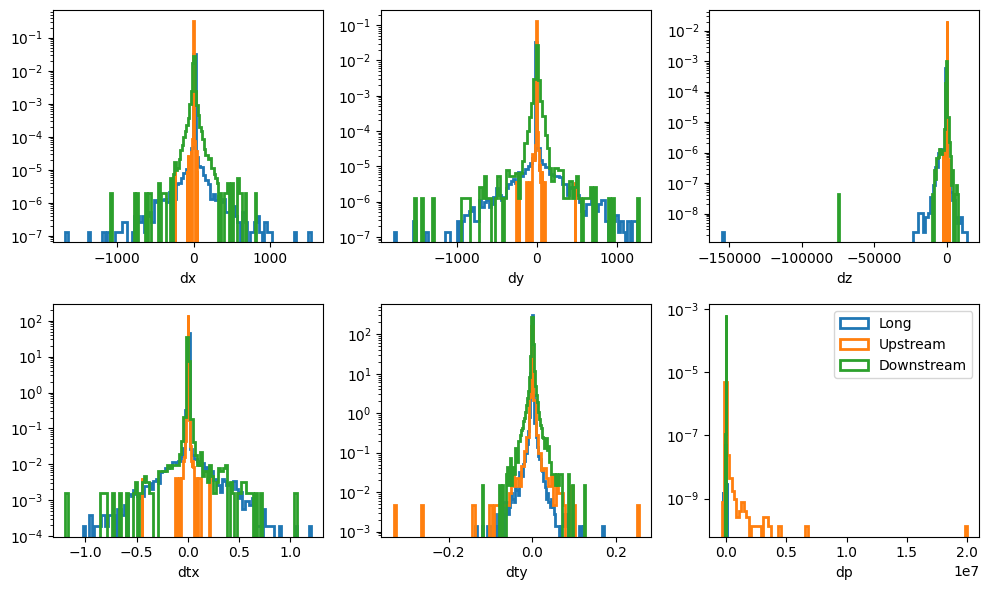

In [10]:
pure_res_vars = res_target[:6]

plt.figure(figsize=(10,6))
for iPlot, var in enumerate(pure_res_vars, 1):
    for track_type in ('long', 'upstream', 'downstream'):
        plt.subplot(2,3,iPlot)
        label=track_type.capitalize()
        plt.hist(df.query(f'{track_type}==1')[var], bins=100, label=label, histtype='step', linewidth=2, density=True)
        plt.xlabel(var)
        plt.yscale('log')
        if iPlot==6: plt.legend()

plt.tight_layout()
plt.show()


# Preprocessing

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer

n_features = len(res_real_conditions)
n_flags = len(res_flags)
n_target = len(res_target)

tX = ColumnTransformer([
    ('features', QuantileTransformer(output_distribution='normal'), np.arange(n_features)),
    ('flags', "passthrough", n_features + np.arange(n_flags)),
]).fit(df[res_conditions].values)

tY = QuantileTransformer(output_distribution='normal').fit(df[res_target].values)

In [13]:
from preprocessing_utils import store_as_pickle, split_and_store

display(store_as_pickle(tX, "RESOLUTION_PREPROCESSING_X", "/workarea/cloud-storage/anderlinil/models/resolution/tX.pkl"))
display(store_as_pickle(tY, "RESOLUTION_PREPROCESSING_Y", "/workarea/cloud-storage/anderlinil/models/resolution/tY.pkl"))

2023-01-02 11:24:55.079571: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [14]:
entries = split_and_store(
    reco[res_conditions + res_target],
    [
        (0.5, environ.get("RESOLUTION_TRAIN", "resolution-train")),
        (0.4, environ.get("RESOLUTION_TEST", "resolution-test")),
        (0.1, environ.get("RESOLUTION_VALIDATION", "resolution-validation"))
    ],
    chunksize=100_000_000,
    features=res_conditions,
    labels=res_target,
    preprocessorX=tX,
    preprocessorY=tY
)
    
pd.DataFrame(entries, index=["Train", "Test", "Validation"])

Processing resolution-train
Processing resolution-test
Processing resolution-validation


,0
Train,352403
Test,282412
Validation,70279


# Covariance preprocessing

In [15]:
def compute_log_cov(df):
    for i in range(5):
        df[f'log_cov_ClosestToBeam_{i}_{i}'] = np.log(df[f'cov_ClosestToBeam_{i}_{i}'])
    return df

def compute_correlation(df):
    for i in range(5):
        for j in range(i):
            cov_ji = df[f'cov_ClosestToBeam_{j}_{i}']
            cov_ii = df[f'cov_ClosestToBeam_{i}_{i}']
            cov_jj = df[f'cov_ClosestToBeam_{j}_{j}']
            
            df[f'corr_ClosestToBeam_{j}_{i}'] = cov_ji/(cov_ii*cov_jj)**0.5
    
    return df

        
cov_real_conditions = [
    'true_x_ClosestToBeam', 'true_y_ClosestToBeam', 'true_z_ClosestToBeam', 
    'true_tx_ClosestToBeam', 'true_ty_ClosestToBeam', 'mc_log10_p',
    'chi2PerDoF', 'nDoF_f', 'ghostProb'
]

cov_flags = ['mc_is_e', 'mc_is_mu', 'mc_is_h', 'long', 'upstream', 'downstream']

cov_diagonals = [f'log_cov_ClosestToBeam_{i}_{i}' for i in range(5)]
cov_corr = [f'corr_ClosestToBeam_{j}_{i}' for i in range(5) for j in range(i)]

cov_conditions = cov_real_conditions + cov_flags
cov_target = cov_diagonals + cov_corr

In [17]:
cov_data = (reco
      .map_partitions(compute_log_cov)
      .map_partitions(compute_correlation)
      [cov_conditions + cov_target]
     )

df = cov_data.head(1_000_000, npartitions=-1)


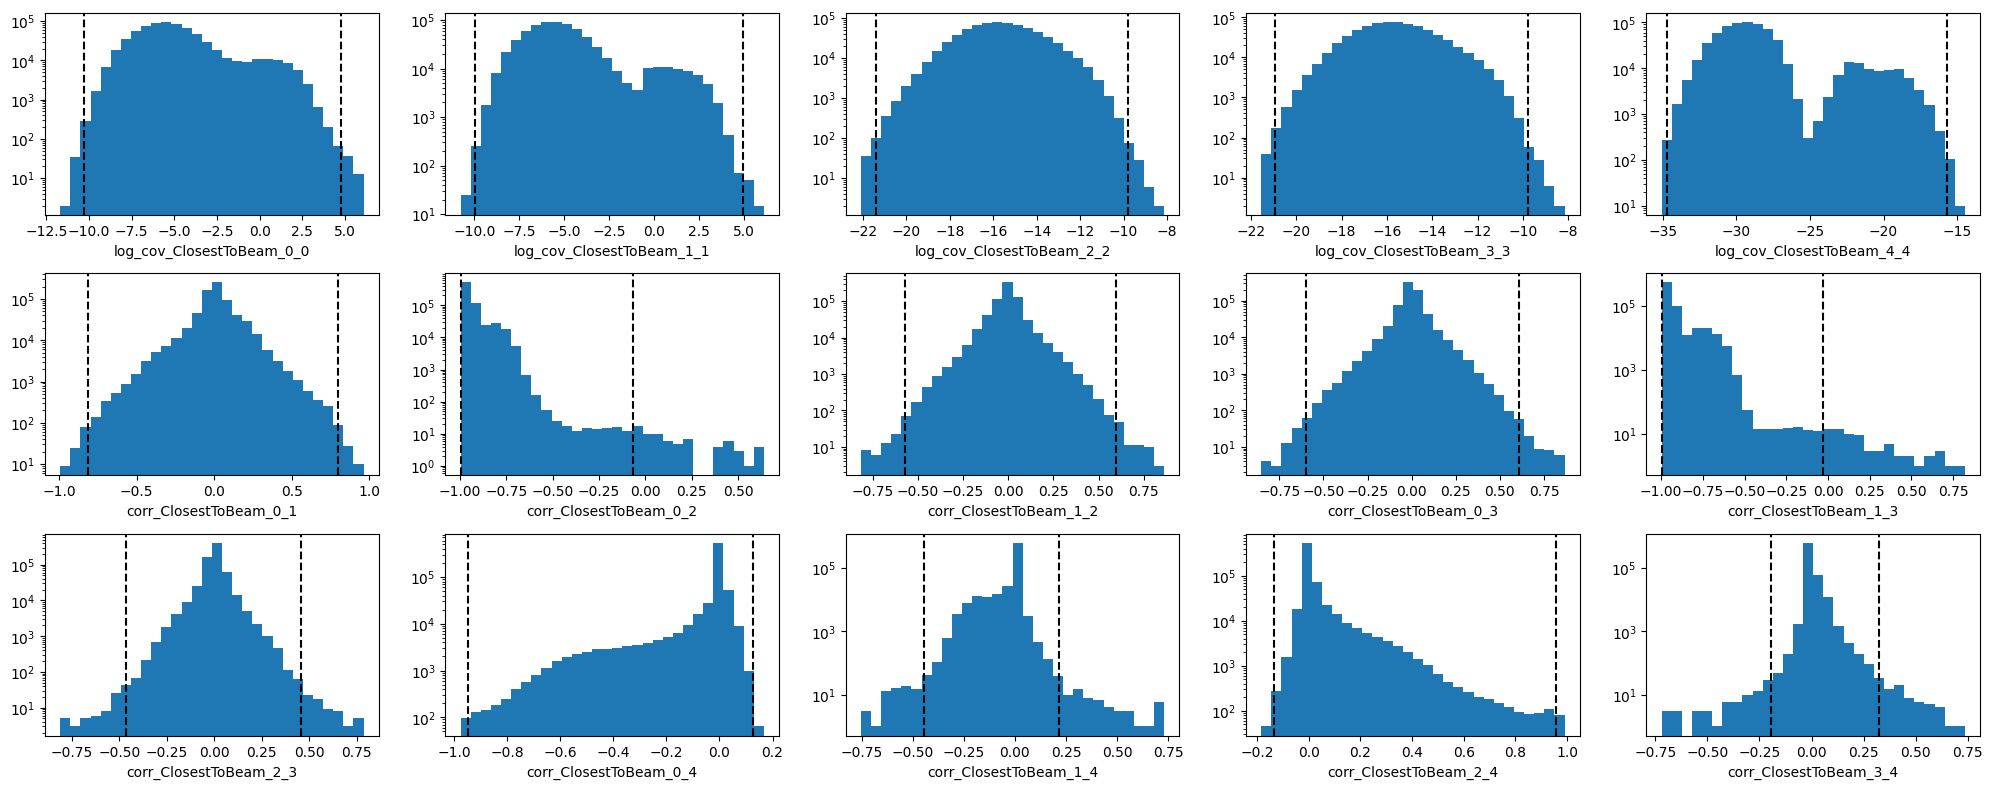

In [27]:
plt.figure(figsize=(20, 8))

df_fig = cov_data[cov_target].head(1_000_000, npartitions=-1)
for iVar, var in enumerate(cov_target, 1):
    plt.subplot(3, 5, iVar)
    low, high = np.quantile(df_fig[var].values, [1e-4, 1-1e-4])
    
    plt.hist(df_fig[var], bins=30)
    plt.yscale('log')
    ylim = plt.ylim()
    plt.plot([low]*2, ylim, 'k--')
    plt.plot([high]*2, ylim, 'k--')
    plt.ylim(ylim)
    plt.xlabel(var)
    

plt.tight_layout()
plt.show()

In [29]:
from preprocessing_utils import DecorrTransformer

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

n_features = len(cov_real_conditions)
n_flags = len(cov_flags)
n_target = len(cov_target)

tX = ColumnTransformer([
    ('features', QuantileTransformer(output_distribution='normal'), np.arange(n_features)),
    ('flags', "passthrough", n_features + np.arange(n_flags)),
]).fit(df[cov_conditions].values)


tY = Pipeline([
    ('minmax', StandardScaler()),
    ('decorr', DecorrTransformer()),
    ('quantile', QuantileTransformer(output_distribution='normal'))
]).fit(df[cov_target].values)
     

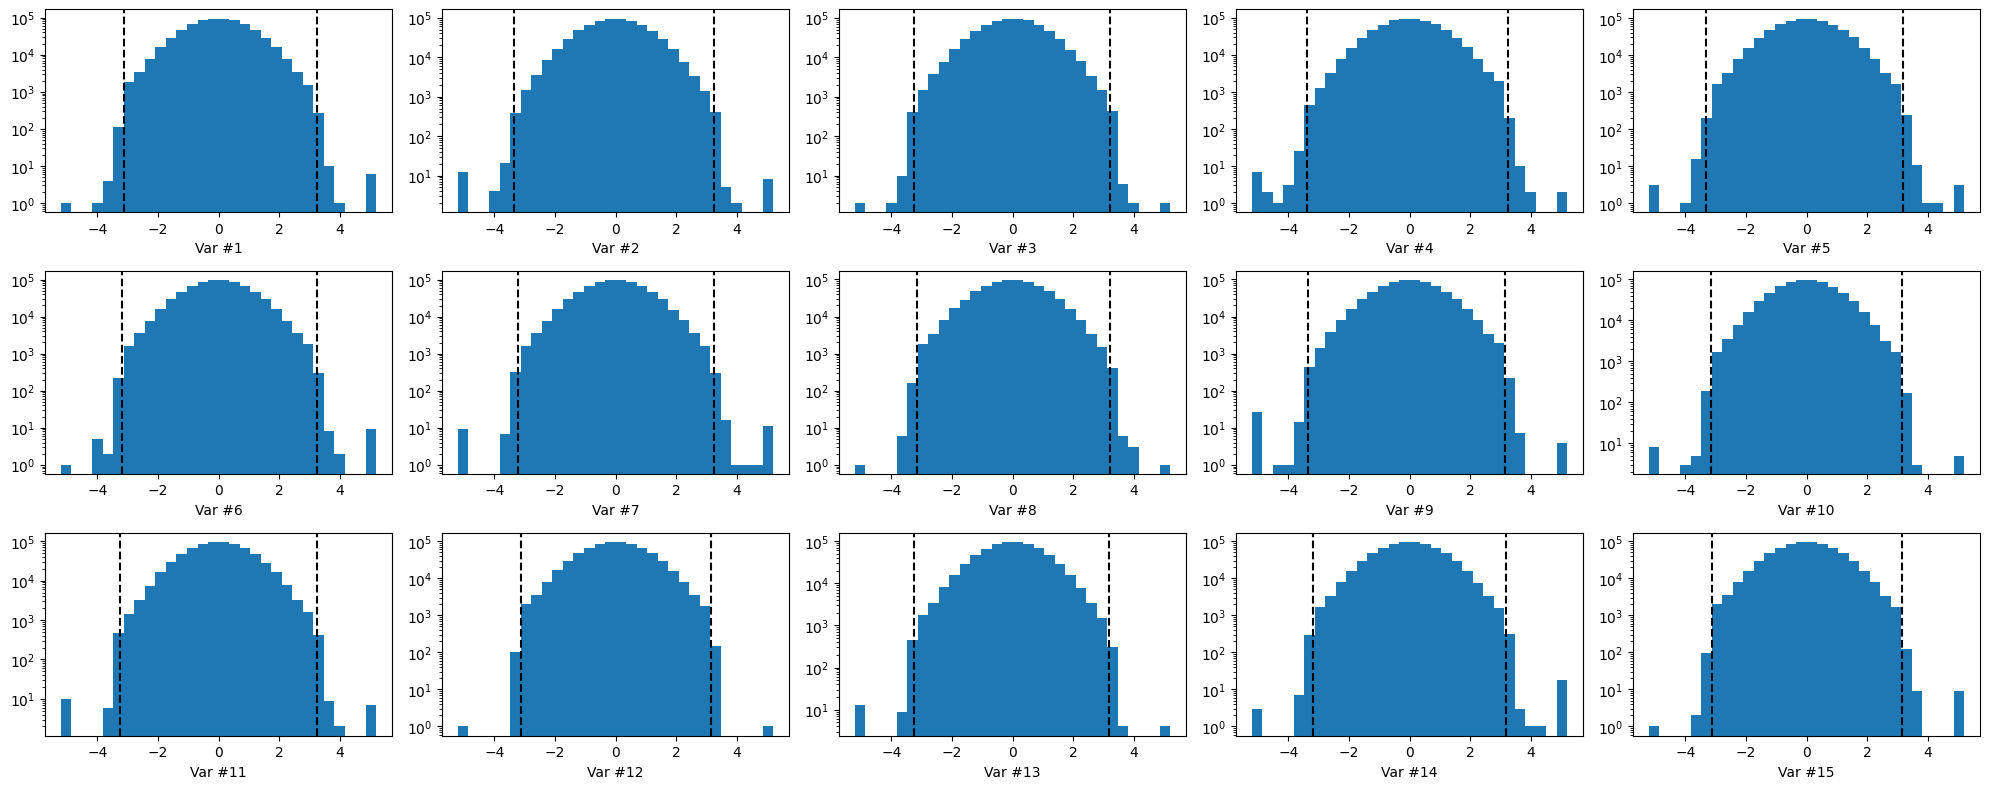

In [31]:
plt.figure(figsize=(20, 8))

df_fig = cov_data[cov_target].head(1_000_000, npartitions=-1)
transformed = tY.transform(df_fig.values)

for iVar, _ in enumerate(cov_target, 1):
    plt.subplot(3, 5, iVar)
    column = transformed[:, iVar-1]
    low, high = np.quantile(column, [1e-4, 1-1e-4])
    
    plt.hist(column, bins=30)
    plt.yscale('log')
    ylim = plt.ylim()
    plt.plot([low]*2, ylim, 'k--')
    plt.plot([high]*2, ylim, 'k--')
    plt.ylim(ylim)
    plt.xlabel(f"Var #{iVar}")
    

plt.tight_layout()
plt.show()

In [ ]:
from preprocessing_utils import store_as_pickle, split_and_store

display(store_as_pickle(tX, "COVARIANCE_PREPROCESSING_X", "/workarea/cloud-storage/anderlinil/models/covariance/tX.pkl"))
display(store_as_pickle(tY, "COVARIANCE_PREPROCESSING_Y", "/workarea/cloud-storage/anderlinil/models/covariance/tY.pkl"))

In [ ]:
entries = split_and_store(
    cov_data,
    [
        (0.5, environ.get("COVARIANCE_TRAIN", "covariance-train")),
        (0.4, environ.get("COVARIANCE_TEST", "covariance-test")),
        (0.1, environ.get("COVARIANCE_VALIDATION", "covariance-validation"))
    ],
    chunksize=100_000_000,
    features=cov_conditions,
    labels=cov_target,
    preprocessorX=tX,
    preprocessorY=tY
)
    
pd.DataFrame(entries, index=["Train", "Test", "Validation"])